# 自前のネットワークを組んで学習させてみる

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.family'] = 'Meiryo'

In [2]:
train_fn = r'./dataset_cur_train.csv'
test_fn = r'./dataset_cur_test.csv'

In [3]:
df_train = pd.read_csv(train_fn,index_col=0)
df_train['red_diff'] = df_train['red_diff'].astype(np.float32)
df_train['remain_ends'] = df_train['remain_ends'].astype(np.float32)
df_train['last_stone_is_red'] = df_train['last_stone_is_red'].astype(np.float32)
df_train['red_postion'] = df_train['red_postion'].astype(np.float32)
display(df_train.dtypes)
display(df_train.head(3))

red_diff             float32
remain_ends          float32
last_stone_is_red    float32
red_postion          float32
filepath              object
dtype: object

,red_diff,remain_ends,last_stone_is_red,red_postion,filepath
8,1.0,0.0,1.0,3.0,./dataset_o\ECC2023_ResultsBook_Women_A-Divisi...
0,2.0,8.0,1.0,0.0,./dataset_o\ECC2021_ResultsBook_Men_A-Division...
8,-2.0,0.0,0.0,3.0,./dataset_o\ECC2019_ResultsBook_Women_A-Divisi...


## red_diff が目的、fn,remain_ends,last_stone_is_red,red_postion が説明変数
説明変数を標準化する

In [ ]:
new_dir_path_recursive = './mynet0212/'
os.makedirs(new_dir_path_recursive, exist_ok=True)

In [4]:
# 標準化
stdsc = StandardScaler()
##学習時の標準化したパラメータは、評価、本番時におなじ重みで標準化する処理が必要
x_train_df = df_train.copy().drop(['filepath','red_diff'],axis=1)
x_train_std = stdsc.fit_transform(x_train_df)
display( x_train_std[:3] )
## DataFrameの値を入れ替え
qcl = df_train.columns.to_list()
qcl.remove('filepath')
qcl.remove('red_diff')
print(qcl)
df_train[qcl] = x_train_std
pickle.dump(stdsc, open(new_dir_path_recursive+"stdsc_02240209.pkl", "wb"))
display(stdsc.n_features_in_, stdsc.mean_ , stdsc.var_) 
df_train.head(5)

array([[-1.5558919 ,  0.9972611 ,  1.2323233 ],
       [ 1.5270197 ,  0.9972611 , -0.01566701],
       [-1.5558919 , -1.0027465 ,  1.2323233 ]], dtype=float32)

['remain_ends', 'last_stone_is_red', 'red_postion']


3

array([4.0374607 , 0.50137133, 0.03766138])

array([6.73376293, 0.24999812, 5.7785669 ])

,red_diff,remain_ends,last_stone_is_red,red_postion,filepath
8,1.0,-1.555892,0.997261,1.232323,./dataset_o\ECC2023_ResultsBook_Women_A-Divisi...
0,2.0,1.527020,0.997261,-0.015667,./dataset_o\ECC2021_ResultsBook_Men_A-Division...
8,-2.0,-1.555892,-1.002746,1.232323,./dataset_o\ECC2019_ResultsBook_Women_A-Divisi...
7,1.0,-1.170528,0.997261,-0.431664,./dataset_o\OWG2018_ResultsBook\geme835end8.png
8,-3.0,-1.555892,-1.002746,0.400330,./dataset_o\WWCC2018_ResultsBook\geme338end9.png


### 20240209_samplescreeningで画像の平均 分散は計算ずみ
平均:[0.5254706740379333, 0.5207158327102661, 0.5373605489730835] 分散[0.47727182507514954, 0.4752059578895569, 0.4878864884376526] :]

In [5]:
import torch
from torchvision import transforms
import torchvision


In [6]:
## 画像変換の定義
w,h = Image.open(df_train['filepath'].values[0]).size
## 正方形にするための差分
pad = (h-w)/2
display([w,h],pad)
target_size = 224
## train用
transform_train = transforms.Compose([
    transforms.Pad(( 240 // 2, 0), fill=0, padding_mode='constant'),  # 左右に余白を追加
    transforms.Resize(target_size),
    transforms.CenterCrop(target_size),
    transforms.RandomHorizontalFlip(0.33),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5254, 0.521, 0.538], std=[0.477, 0.475, 0.487])
])
# valid/test用
transform_test = transforms.Compose([
    transforms.Pad(( 240 // 2, 0), fill=0, padding_mode='constant'),  # 左右に余白を追加
    transforms.Resize(target_size),
    transforms.CenterCrop(target_size),
    transforms.RandomHorizontalFlip(0.33),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5254, 0.521, 0.538], std=[0.477, 0.475, 0.487])
])

[300, 540]

120.0

In [7]:
from torch.utils.data import DataLoader, Dataset

# 自前のデータセット定義

In [8]:
class ImgValueDataset(Dataset):
    def __init__(self, df, classcol , fncol , transform):
        
        ##self.label_list  = df[classcol].to_list()
        class_data = pd.get_dummies(df[classcol]).values
        self.label_list  = class_data.astype(float)
        
        self.img_pathlist  = df[fncol].to_list()
        cols = df.columns.to_list()
        cols.remove(fncol)
        cols.remove(classcol)
        self.x_values = df[cols].values
        self.transform = transform

    def __len__(self):  
        return len( self.img_pathlist )
    
    def __getitem__(self, index):
        # 画像をPILとして読み込む
        #print(index,self.img_pathlist[index])
        image = Image.open(self.img_pathlist[index])
        
        label = self.label_list[index]
                             
        if self.transform is not None:
            ##print('use transform')
            image = self.transform(image)
        return image, label 
    pass

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_train, test_size=0.2, stratify=df_train['red_diff'])
train_dataset = ImgValueDataset( train_df ,classcol='red_diff' , fncol='filepath',transform=transform_train)
test_dataset = ImgValueDataset( test_df ,classcol='red_diff' , fncol='filepath' ,transform=transform_test)
len(train_df)

11959

In [10]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [11]:
train_loader.__len__()

2990

In [12]:
images, labels = next(iter(train_loader))
images.shape , labels

(torch.Size([4, 3, 224, 224]),
 tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=torch.float64))

In [13]:
class_list = train_df['red_diff'].unique()
class_list , len(class_list)

(array([-1.,  0., -2.,  3.,  1., -3.,  4.,  2., -4.,  5., -5.],
       dtype=float32),
 11)

# ネットを組む  
https://qiita.com/poorko/items/c151ff4a827f114fe954

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# CNNモデルの定義
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=1)

        viewCnt = (48 * 28 * 28)
        
        self.fc1 = nn.Linear(viewCnt, 256)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = x
        #print('input:',input.shape)
        
        output = self.pool(F.relu(self.conv1(input)))
        output = self.pool(F.relu(self.conv2(output)))
        output = self.pool(F.relu(self.conv3(output)))
        #print('conv:',output.shape)
        output = output.view(-1, 48 * 28 * 28)
        #print('view:',output.shape)
        ## -- 結合します
        #params = values[:,0,1,0:3]
        #packedData = torch.cat([images,params],1)
        #print(images.shape,values.shape,packedData.shape)
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [16]:
net = SimpleCNN(11)
print(net)

SimpleCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=37632, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=11, bias=True)
)


## 損失関数とオプティマイザ

In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

## 訓練（ネットワークが通るか確認）  
https://atmarkit.itmedia.co.jp/ait/articles/2006/12/news021.html

In [18]:
def plot_graph(values1, values2, rng, label1, label2):
    plt.plot(range(rng), values1, label=label1)
    plt.plot(range(rng), values2, label=label2)
    plt.legend()
    plt.grid()
    plt.show()

In [19]:
def train(net, dataloader, criterion, optimizer,device):
    net.train()

    total_loss = 0.0
    total_correct = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print('入力:',inputs.shape , labels.shape,labels.dtype)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        #print('評価:',outputs.shape , labels.shape,labels.dtype)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, ons_labels = torch.max(labels, 1)
        total_correct += (predicted == ons_labels).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = total_correct / len(dataloader.dataset)

    return avg_loss, accuracy

def validate(net, dataloader, criterion,device):
    net.eval()

    with torch.no_grad():
        total_loss = 0.0
        total_correct = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, ons_labels = torch.max(labels, 1)
            total_correct += (predicted == ons_labels).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_accuracy = total_correct / len(dataloader.dataset)

    return avg_loss, avg_accuracy

In [20]:
def do_train_and_validate(net, trainset, criterion, optimizer, epochs,device):
    best_accuracy = 0.0
    trainloader, validloader = trainset

    history = {}
    history['train_loss_values'] = []
    history['train_accuracy_values'] = []
    history['valid_loss_values'] = []
    history['valid_accuracy_values'] = []

    for epoch in range(1, epochs + 1):
        current_time = datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
        print(f'epoch: {epoch:3} <{formatted_time}>')

        t_loss, t_accu = train(net, trainloader, criterion, optimizer,device)
        v_loss, v_accu = validate(net, validloader, criterion,device)

        print(f'train_loss: {t_loss:.6f}, train_accuracy: {t_accu:3.4%},',
              f'valid_loss: {v_loss:.6f}, valid_accuracy: {v_accu:3.4%}')

        history['train_loss_values'].append(t_loss)
        history['train_accuracy_values'].append(t_accu)
        history['valid_loss_values'].append(v_loss)
        history['valid_accuracy_values'].append(v_accu)
        if best_accuracy < v_accu:
            best_accuracy = v_accu
            model_scripted = torch.jit.script(net)
            model_scripted.save(new_dir_path_recursive+f'model_scripted_{epoch}.smodel.pth')
            
    return history

In [21]:

train_dataset = ImgValueDataset( train_df[:32*20] ,classcol='red_diff' , fncol='filepath',transform=transform_train)
test_dataset = ImgValueDataset( test_df ,classcol='red_diff' , fncol='filepath' ,transform=transform_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

net = SimpleCNN(11).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
EPOCHS = 100
trainset = [train_loader,test_loader]

history = do_train_and_validate(net, trainset, criterion, optimizer, EPOCHS,device)


cuda
epoch:   1 <2024-02-11 16:16:41>
train_loss: 0.073680, train_accuracy: 20.6250%, valid_loss: 0.071862, valid_accuracy: 24.8829%
epoch:   2 <2024-02-11 16:17:21>
train_loss: 0.066881, train_accuracy: 29.8438%, valid_loss: 0.063506, valid_accuracy: 24.8829%
epoch:   3 <2024-02-11 16:18:01>
train_loss: 0.061286, train_accuracy: 30.3125%, valid_loss: 0.060847, valid_accuracy: 24.8829%
epoch:   4 <2024-02-11 16:18:41>
train_loss: 0.060991, train_accuracy: 28.9062%, valid_loss: 0.060440, valid_accuracy: 24.8829%
epoch:   5 <2024-02-11 16:19:22>
train_loss: 0.060208, train_accuracy: 28.2813%, valid_loss: 0.060125, valid_accuracy: 24.8829%
epoch:   6 <2024-02-11 16:20:02>
train_loss: 0.060199, train_accuracy: 27.5000%, valid_loss: 0.060135, valid_accuracy: 24.8829%
epoch:   7 <2024-02-11 16:20:41>
train_loss: 0.060015, train_accuracy: 27.9687%, valid_loss: 0.060025, valid_accuracy: 24.8829%
epoch:   8 <2024-02-11 16:21:19>
train_loss: 0.059650, train_accuracy: 27.6562%, valid_loss: 0.0600

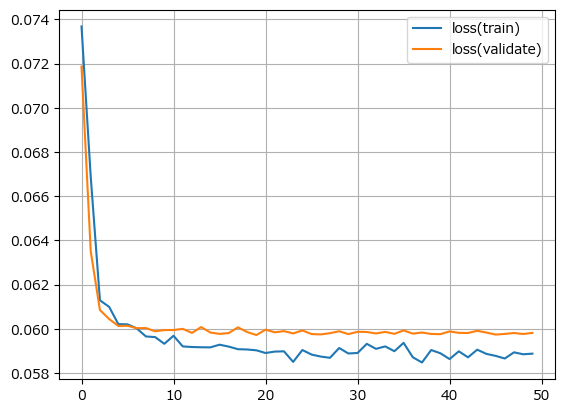

In [22]:
t_losses = history['train_loss_values']
t_accus = history['train_accuracy_values']
v_losses = history['valid_loss_values']
v_accus = history['valid_accuracy_values']

plot_graph(t_losses, v_losses, EPOCHS, 'loss(train)', 'loss(validate)')

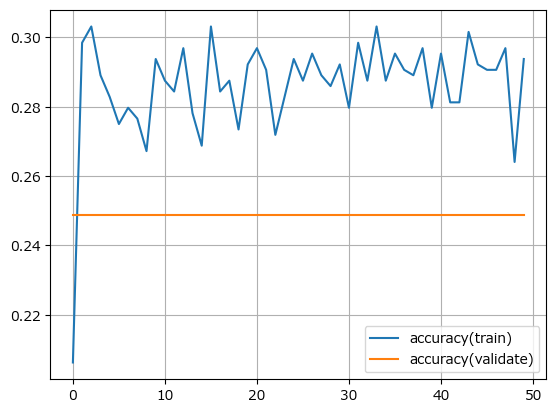

In [23]:
plot_graph(t_accus, v_accus, EPOCHS, 'accuracy(train)', 'accuracy(validate)')

## 取り置きのテスト画像群

In [84]:
test_fn = r'./dataset_cur_test.csv'
test_fn

'./dataset_cur_test.csv'

In [85]:
df_test = pd.read_csv(test_fn,index_col=0)
df_test = df_test.reset_index(drop=True)
df_test['red_diff'] = df_test['red_diff'].astype(np.float32)
df_test['remain_ends'] = df_test['remain_ends'].astype(np.float32)
df_test['last_stone_is_red'] = df_test['last_stone_is_red'].astype(np.float32)
df_test['red_postion'] = df_test['red_postion'].astype(np.float32)
display(df_test.dtypes)
display(df_test.head(3))

red_diff             float32
remain_ends          float32
last_stone_is_red    float32
red_postion          float32
filepath              object
dtype: object

,red_diff,remain_ends,last_stone_is_red,red_postion,filepath
0,-1.0,7.0,0.0,1.0,./dataset_o\WWCC2019_ResultsBook\geme428end2.png
1,-2.0,1.0,0.0,2.0,./dataset_o\WWCC2019_ResultsBook\geme531end8.png
2,2.0,7.0,1.0,0.0,./dataset_o\ECC2019_ResultsBook_Women_A-Divisi...


In [86]:
# 標準化
_stdsc = StandardScaler()
##学習時の標準化したパラメータは、評価、本番時におなじ重みで標準化する処理が必要
x_test_df = df_test.copy().drop(['filepath','red_diff'],axis=1)
sc = pickle.load(open(new_dir_path_recursive+'stdsc_02240209.pkl', "rb"))
x_test_std = sc.transform(x_test_df)

## DataFrameの値を入れ替え
qcl = df_test.columns.to_list()
qcl.remove('filepath')
qcl.remove('red_diff')
print(qcl)
df_test[qcl] = x_test_std
#df_test.head(3)

['remain_ends', 'last_stone_is_red', 'red_postion']


In [87]:
q_test = ImgValueDataset( df_test ,classcol='red_diff' , fncol='filepath' ,transform=transform_test)

In [89]:
## ベストモデル
import glob
##'model_scripted_{epoch}.smodel.pth'
g = glob.glob(new_dir_path_recursive+'model_scripted_*.smodel.pth')
g.sort()
fn = g[0]
print(fn)
model_from_script = torch.jit.load(fn, map_location="cuda")
print(type(model_from_script))

model_scripted_1.smodel.pth
<class 'torch.jit._script.RecursiveScriptModule'>


In [90]:
q_loader = DataLoader(q_test, batch_size=batch_size, shuffle=False, num_workers=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu_model = model_from_script.to(device)
with torch.no_grad():
    accs = [] # 各バッチごとの結果格納用
    for batch in q_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        y = gpu_model(x)
        
        y_label = torch.argmax(y, dim=1)
        t_label = torch.argmax(t, dim=1)
        acc = torch.sum(y_label == t_label) * 1.0 / len(t)
        accs.append(acc)
    

In [91]:
np.mean( list(map( lambda r:r.item() ,accs )) )

0.24863229434077555